<a href="https://colab.research.google.com/github/olhaishchenko/-data_science/blob/master/HW_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практика з RNN за допомогою Keras:**

In [104]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, Dropout, TimeDistributed

In [105]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    os.environ["TF_DETERMINISTIC_OPS"] = "true"


set_seed(42)

Встановлюємо гіперпараметри:

In [106]:
max_features = 10000  # кількість слів, що розглядаються як особливості
maxlen = 500  # обмеження кількості слів в тексті
batch_size = 128

Завантаження даних:

In [107]:
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
# Завантаження тренувальних та тестових даних зі вказанням обмеження на кількість слів

Передпроцесинг послідовних даних:

In [108]:
input_train = pad_sequences(input_train, maxlen=maxlen)
input_test = pad_sequences(input_test, maxlen=maxlen)
# Застосування заздалегідь обраної максимальної довжини до послідовних даних тренувального та тестового наборів
# обрізає спочатку зайві слова, або додає 0

In [109]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, x, y, shuffle=True, batch_size=256):
        self.x = x
        self.y = y
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.x))
        self.batch_size = batch_size

        if shuffle:
            self.on_epoch_end()

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def __getitem__(self, n):
        indexes = self.indexes[n * self.batch_size : (n + 1) * self.batch_size]
        batch_x = self.x[indexes]
        # batch_y = self.y[indexes]
        batch_y = [self.y[i] for i in indexes]

        return batch_x, np.array(batch_y)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [110]:
x_train_part, x_valid, y_train_part, y_valid = train_test_split(input_train, y_train, test_size=0.2, shuffle=True)

In [111]:
train_dataset = Dataset(x_train_part, y_train_part, shuffle=True, batch_size=batch_size)
valid_dataset = Dataset(x_valid, y_valid, shuffle=False, batch_size=batch_size)

In [114]:
model = Sequential([
    Embedding(max_features, 64),
    # Dropout(0.2),
    SimpleRNN(32),
    # TimeDistributed(Dense(1, activation='sigmoid'))
    Dense(1, activation="sigmoid")
])

In [115]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 64)          640000    
                                                                 
 simple_rnn_16 (SimpleRNN)   (None, 32)                3104      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 643,137
Trainable params: 643,137
Non-trainable params: 0
_________________________________________________________________


In [116]:
callback_early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=2,
    verbose=1
)


callback_save = ModelCheckpoint(
    "best_rnn.hdf5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [117]:
model.compile(
    optimizer='adam',
    loss="binary_crossentropy",
    metrics=['acc'],
)

In [118]:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=10,
    verbose=1,
    callbacks=[callback_early_stopping, callback_save]
)

Epoch 1/10
156/156 [==============================] - ETA: 0s - loss: 0.5946 - acc: 0.6714
Epoch 1: val_loss improved from inf to 0.45183, saving model to best_rnn.hdf5
156/156 [==============================] - 36s 215ms/step - loss: 0.5946 - acc: 0.6714 - val_loss: 0.4518 - val_acc: 0.8035
Epoch 2/10
156/156 [==============================] - ETA: 0s - loss: 0.3647 - acc: 0.8485
Epoch 2: val_loss improved from 0.45183 to 0.38706, saving model to best_rnn.hdf5
156/156 [==============================] - 33s 209ms/step - loss: 0.3647 - acc: 0.8485 - val_loss: 0.3871 - val_acc: 0.8391
Epoch 3/10
156/156 [==============================] - ETA: 0s - loss: 0.2152 - acc: 0.9173
Epoch 3: val_loss improved from 0.38706 to 0.35769, saving model to best_rnn.hdf5
156/156 [==============================] - 34s 219ms/step - loss: 0.2152 - acc: 0.9173 - val_loss: 0.3577 - val_acc: 0.8570
Epoch 4/10
156/156 [==============================] - ETA: 0s - loss: 0.1133 - acc: 0.9624
Epoch 4: val_loss did 

In [119]:
model.save_weights("my_model_rnn.hdf5")

Побудова простої моделі RNN:

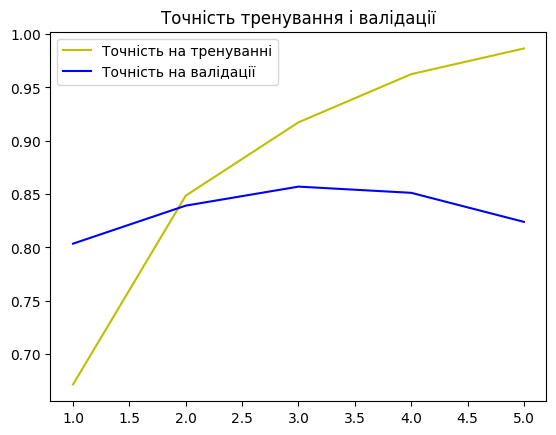

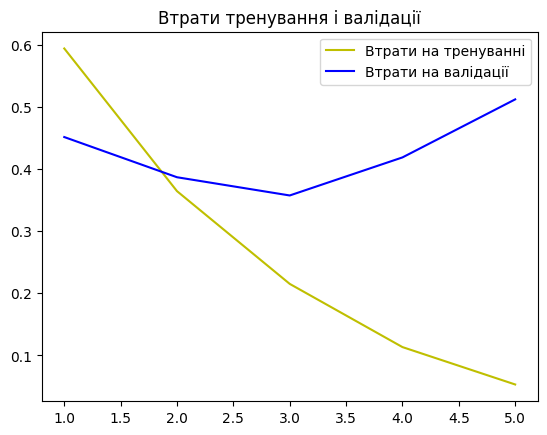

In [120]:
# Відображення результатів:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'y', label='Точність на тренуванні')  # Графік точності на тренувальних данних
plt.plot(epochs, val_acc, 'b', label='Точність на валідації')  # Графік точності на валідаційних данних
plt.title('Точність тренування і валідації')  # Заголовок графіку
plt.legend()  # Показати легенду

plt.figure()

plt.plot(epochs, loss, 'y', label='Втрати на тренуванні')  # Графік втрат на тренувальних данних
plt.plot(epochs, val_loss, 'b', label='Втрати на валідації')  # Графік втрат на валідаційних данних
plt.title('Втрати тренування і валідації')  # Заголовок графіку
plt.legend()  # Показати легенду

plt.show()  # Відобразити графіки

In [121]:
# Прогнозування з використанням навченої моделі:

predictions = model.predict(input_test)

# Для отримання зрозумілішого вигляду прогнозів, їх можна перетворити в бінарний формат:
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Для порівняння можна вивести деякі прогнозовані значення поряд з фактичними значеннями
for i in range(10):
    print(f"Прогнозоване: {binary_predictions[i]}, Фактичне: {y_test[i]}")


782/782 [==============================] - 23s 29ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1


In [122]:

# Додатковий крок: Оцінка моделі
# Це дасть загальну точність моделі на тестових даних
test_loss, test_acc = model.evaluate(input_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 23s 30ms/step - loss: 0.5199 - acc: 0.8127
Test Loss: 0.5199316143989563
Test Accuracy: 0.812720000743866


# **Практика з GRU за допомогою Keras:**

In [ ]:
# Завантаження відкритих даних:

import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense

In [ ]:
# Встановлюємо гіперпараметри:

max_features = 10000  # кількість слів, що розглядаються як особливості
maxlen = 500  # обмеження кількості слів в тексті
batch_size = 32

# Завантаження даних:

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
# Завантаження тренувальних та тестових даних зі вказанням обмеження на кількість слів


# Передпроцесинг послідовних даних:

input_train = pad_sequences(input_train, maxlen=maxlen)
input_test = pad_sequences(input_test, maxlen=maxlen)
# Застосування заздалегідь обраної максимальної довжини до послідовних даних тренувального та тестового наборів

17464789/17464789 [==============================] - 0s 0us/step


In [ ]:

# Побудова моделі RNN:

model = Sequential()
# Створення порожньої моделі Sequential

# Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
model.add(Embedding(max_features, 32))
# Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово

# Додавання GRU шару з 32 вузлами
model.add(GRU(32))
# Параметр: кількість вузлів (розмір прихованого стану)

# Додавання Dense шару з одним вузлом та активацією sigmoid
model.add(Dense(1, activation='sigmoid'))
# Параметри: кількість вузлів (вихідний розмір) та функція активації (sigmoid для бінарної класифікації)

In [ ]:
# Компіляція моделі:

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# Виведення опису моделі:

model.summary()

# Навчання моделі:

history = model.fit(input_train, y_train, epochs=5, batch_size=128, validation_split=0.3)
# Запускаємо навчання моделі на тренувальних даних для 5 епох з розміром пакету 128 та розбиттям на тренувальну та валідаційну підмножини


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 326,369
Trainable params: 326,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
137/137 [==============================] - 33s 230ms/step - loss: 0.6402 - acc: 0.6187 - val_loss: 0.4468 - val_acc: 0.7928
Epoch 2/5
137/137 [==============================] - 29s 213ms/step - loss: 0.3776 - acc: 0.8369 - val_loss: 0.3791 - val_acc: 0.8337
Epoch 3/5
137/137 [===========================

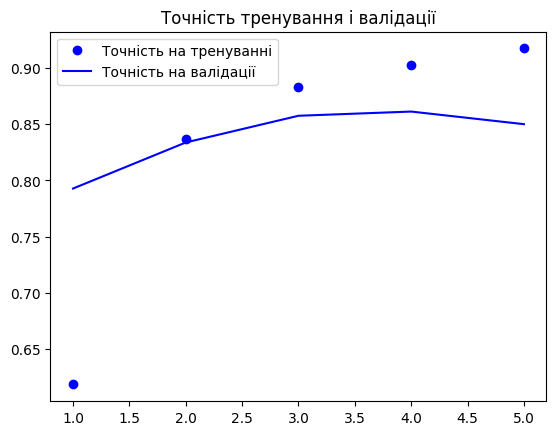

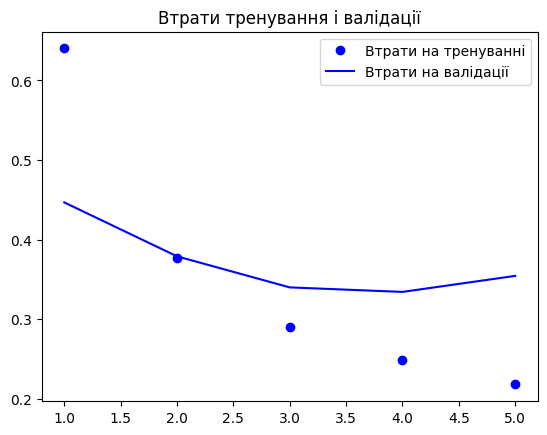

In [ ]:
# Відображення результатів:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Точність на тренуванні')  # Графік точності на тренувальних данних
plt.plot(epochs, val_acc, 'b', label='Точність на валідації')  # Графік точності на валідаційних данних
plt.title('Точність тренування і валідації')  # Заголовок графіку
plt.legend()  # Показати легенду

plt.figure()

plt.plot(epochs, loss, 'bo', label='Втрати на тренуванні')  # Графік втрат на тренувальних данних
plt.plot(epochs, val_loss, 'b', label='Втрати на валідації')  # Графік втрат на валідаційних данних
plt.title('Втрати тренування і валідації')  # Заголовок графіку
plt.legend()  # Показати легенду

plt.show()  # Відобразити графіки



In [ ]:

# Прогнозування з використанням навченої моделі:

predictions = model.predict(input_test)

# Для отримання зрозумілішого вигляду прогнозів, їх можна перетворити в бінарний формат:
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Для порівняння можна вивести деякі прогнозовані значення поряд з фактичними значеннями
for i in range(10):
    print(f"Прогнозоване: {binary_predictions[i]}, Фактичне: {y_test[i]}")

# Додатковий крок: Оцінка моделі
# Це дасть загальну точність моделі на тестових даних
test_loss, test_acc = model.evaluate(input_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 20s 25ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 [==============================] - 20s 26ms/step - loss: 0.3636 - acc: 0.8456
Test Loss: 0.36363133788108826
Test Accuracy: 0.8456400036811829


# **Практика з LSTM за допомогою Keras:**

In [ ]:
# Завантаження відкритих даних:

import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense


In [ ]:
# Встановлюємо гіперпараметри:

max_features = 10000  # кількість слів, що розглядаються як особливості
maxlen = 500  # обмеження кількості слів в тексті
batch_size = 32

# Завантаження даних:

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
# Завантаження тренувальних та тестових даних зі вказанням обмеження на кількість слів


# Передпроцесинг послідовних даних:

input_train = pad_sequences(input_train, maxlen=maxlen)
input_test = pad_sequences(input_test, maxlen=maxlen)
# Застосування заздалегідь обраної максимальної довжини до послідовних даних тренувального та тестового наборів

In [ ]:
# Побудова моделі LSTM:

model = Sequential()
# Створення порожньої моделі Sequential

# Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
model.add(Embedding(max_features, 32))
# Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово

# Додавання LSTM шару з 32 вузлами
model.add(LSTM(32))
# Параметр: кількість вузлів (розмір прихованого стану)

# Додавання Dense шару з одним вузлом та активацією sigmoid
model.add(Dense(1, activation='sigmoid'))
# Параметри: кількість вузлів (вихідний розмір) та функція активації (sigmoid для бінарної класифікації)


# Компіляція моделі:

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# Виведення опису моделі:

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Навчання моделі:

history = model.fit(input_train, y_train, epochs=5, batch_size=128, validation_split=0.3)
# Запускаємо навчання моделі на тренувальних даних для 5 епох з розміром пакету 128 та розбиттям на тренувальну та валідаційну підмножини


Epoch 1/5
137/137 [==============================] - 38s 266ms/step - loss: 0.6263 - acc: 0.6401 - val_loss: 0.5015 - val_acc: 0.7835
Epoch 2/5
137/137 [==============================] - 33s 240ms/step - loss: 0.3868 - acc: 0.8420 - val_loss: 0.3584 - val_acc: 0.8468
Epoch 3/5
137/137 [==============================] - 32s 237ms/step - loss: 0.2909 - acc: 0.8870 - val_loss: 0.2952 - val_acc: 0.8775
Epoch 4/5
137/137 [==============================] - 32s 232ms/step - loss: 0.2375 - acc: 0.9125 - val_loss: 0.3169 - val_acc: 0.8765
Epoch 5/5
137/137 [==============================] - 34s 248ms/step - loss: 0.2072 - acc: 0.9245 - val_loss: 0.3097 - val_acc: 0.8668


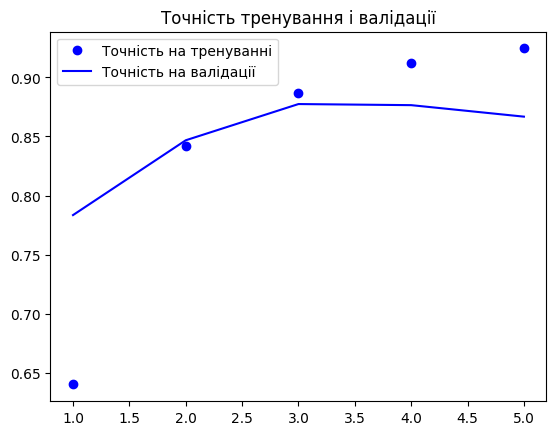

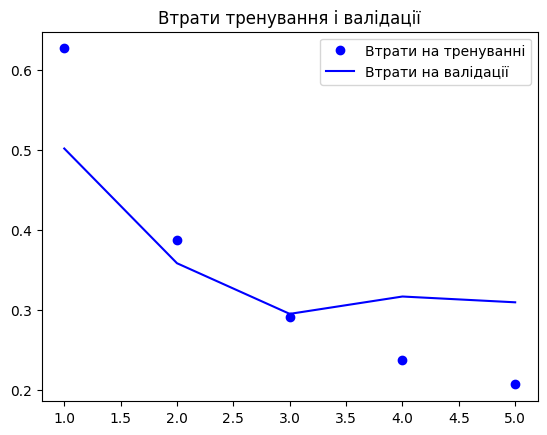

In [ ]:
# Відображення результатів:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Точність на тренуванні')  # Графік точності на тренувальних данних
plt.plot(epochs, val_acc, 'b', label='Точність на валідації')  # Графік точності на валідаційних данних
plt.title('Точність тренування і валідації')  # Заголовок графіку
plt.legend()  # Показати легенду

plt.figure()

plt.plot(epochs, loss, 'bo', label='Втрати на тренуванні')  # Графік втрат на тренувальних данних
plt.plot(epochs, val_loss, 'b', label='Втрати на валідації')  # Графік втрат на валідаційних данних
plt.title('Втрати тренування і валідації')  # Заголовок графіку
plt.legend()  # Показати легенду

plt.show()  # Відобразити графіки



In [ ]:

# Прогнозування з використанням навченої моделі:

predictions = model.predict(input_test)

# Для отримання зрозумілішого вигляду прогнозів, їх можна перетворити в бінарний формат:
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Для порівняння можна вивести деякі прогнозовані значення поряд з фактичними значеннями
for i in range(10):
    print(f"Прогнозоване: {binary_predictions[i]}, Фактичне: {y_test[i]}")

# Додатковий крок: Оцінка моделі
# Це дасть загальну точність моделі на тестових даних
test_loss, test_acc = model.evaluate(input_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 23s 29ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 [==============================] - 23s 30ms/step - loss: 0.3162 - acc: 0.8661
Test Loss: 0.316188782453537
Test Accuracy: 0.8661199808120728


# **Практика з BRNN за допомогою Keras:**

In [ ]:
# Завантаження відкритих даних:

import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense

In [ ]:
# Встановлюємо гіперпараметри:

max_features = 10000  # кількість слів, що розглядаються як особливості
maxlen = 500  # обмеження кількості слів в тексті
batch_size = 32

# Завантаження даних:

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
# Завантаження тренувальних та тестових даних зі вказанням обмеження на кількість слів


# Передпроцесинг послідовних даних:

input_train = pad_sequences(input_train, maxlen=maxlen)
input_test = pad_sequences(input_test, maxlen=maxlen)
# Застосування заздалегідь обраної максимальної довжини до послідовних даних тренувального та тестового наборів


In [ ]:
# Побудова моделі LSTM:

model = Sequential()
# Створення порожньої моделі Sequential

# Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
model.add(Embedding(max_features, 32))
# Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово

# Додавання Bidirectional LSTM шару з 32 вузлами
model.add(Bidirectional(LSTM(32)))
# Параметр: кількість вузлів (розмір прихованого стану)

# Додавання Dense шару з одним вузлом та активацією sigmoid
model.add(Dense(1, activation='sigmoid'))
# Параметри: кількість вузлів (вихідний розмір) та функція активації (sigmoid для бінарної класифікації)


# Компіляція моделі:

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# Виведення опису моделі:

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 336,705
Trainable params: 336,705
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Навчання моделі:

history = model.fit(input_train, y_train, epochs=5, batch_size=128, validation_split=0.3)
# Запускаємо навчання моделі на тренувальних даних для 5 епох з розміром пакету 128 та розбиттям на тренувальну та валідаційну підмножини


Epoch 1/5
137/137 [==============================] - 59s 412ms/step - loss: 0.6546 - acc: 0.6015 - val_loss: 0.5263 - val_acc: 0.7877
Epoch 2/5
137/137 [==============================] - 54s 398ms/step - loss: 0.4275 - acc: 0.8210 - val_loss: 0.3497 - val_acc: 0.8540
Epoch 3/5
137/137 [==============================] - 55s 404ms/step - loss: 0.3462 - acc: 0.8646 - val_loss: 0.3329 - val_acc: 0.8620
Epoch 4/5
137/137 [==============================] - 54s 397ms/step - loss: 0.2540 - acc: 0.9050 - val_loss: 0.3224 - val_acc: 0.8807
Epoch 5/5
137/137 [==============================] - 53s 390ms/step - loss: 0.2207 - acc: 0.9163 - val_loss: 0.2939 - val_acc: 0.8752


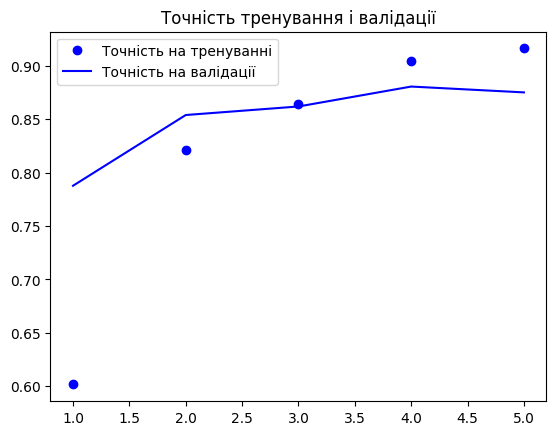

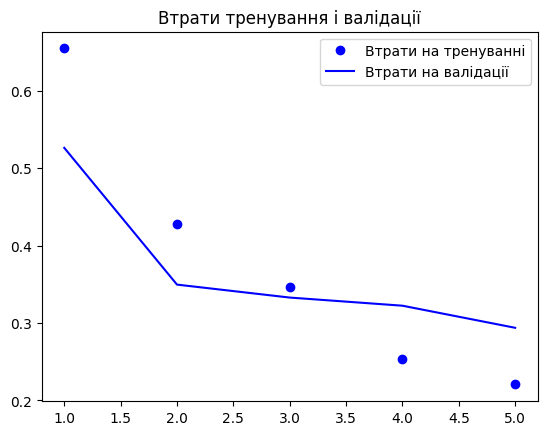

In [ ]:
# Відображення результатів:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Точність на тренуванні')  # Графік точності на тренувальних данних
plt.plot(epochs, val_acc, 'b', label='Точність на валідації')  # Графік точності на валідаційних данних
plt.title('Точність тренування і валідації')  # Заголовок графіку
plt.legend()  # Показати легенду

plt.figure()

plt.plot(epochs, loss, 'bo', label='Втрати на тренуванні')  # Графік втрат на тренувальних данних
plt.plot(epochs, val_loss, 'b', label='Втрати на валідації')  # Графік втрат на валідаційних данних
plt.title('Втрати тренування і валідації')  # Заголовок графіку
plt.legend()  # Показати легенду

plt.show()  # Відобразити графіки



In [ ]:

# Прогнозування з використанням навченої моделі:

predictions = model.predict(input_test)

# Для отримання зрозумілішого вигляду прогнозів, їх можна перетворити в бінарний формат:
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Для порівняння можна вивести деякі прогнозовані значення поряд з фактичними значеннями
for i in range(10):
    print(f"Прогнозоване: {binary_predictions[i]}, Фактичне: {y_test[i]}")

# Додатковий крок: Оцінка моделі
# Це дасть загальну точність моделі на тестових даних
test_loss, test_acc = model.evaluate(input_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 36s 45ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 [==============================] - 36s 46ms/step - loss: 0.3056 - acc: 0.8721
Test Loss: 0.30556464195251465
Test Accuracy: 0.8720800280570984


# **Практика з Deep BRNN за допомогою Keras:**

In [ ]:
# Завантаження відкритих даних:

import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense

In [ ]:
# Встановлюємо гіперпараметри:

max_features = 10000  # кількість слів, що розглядаються як особливості
maxlen = 500  # обмеження кількості слів в тексті
batch_size = 32

# Завантаження даних:

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
# Завантаження тренувальних та тестових даних зі вказанням обмеження на кількість слів


# Передпроцесинг послідовних даних:

input_train = pad_sequences(input_train, maxlen=maxlen)
input_test = pad_sequences(input_test, maxlen=maxlen)
# Застосування заздалегідь обраної максимальної довжини до послідовних даних тренувального та тестового наборів

In [ ]:

# Побудова моделі LSTM:

model = Sequential()
# Створення порожньої моделі Sequential

# Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
model.add(Embedding(max_features, 32))
# Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово

# Додавання декількох Bidirectional LSTM шару з 32 вузлами
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
# Параметр: кількість вузлів (розмір прихованого стану) і return_sequences=True для першого шару, щоб надати послідовність як вхід на наступний шар

# Додавання Dense шару з одним вузлом та активацією sigmoid
model.add(Dense(1, activation='sigmoid'))
# Параметри: кількість вузлів (вихідний розмір) та функція активації (sigmoid для бінарної класифікації)


# Компіляція моделі:

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# Виведення опису моделі:

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          320000    
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 64)         16640     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 361,537
Trainable params: 361,537
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Навчання моделі:

history = model.fit(input_train, y_train, epochs=5, batch_size=128, validation_split=0.3)
# Запускаємо навчання моделі на тренувальних даних для 5 епох з розміром пакету 128 та розбиттям на тренувальну та валідаційну підмножини


Epoch 1/5
137/137 [==============================] - 129s 902ms/step - loss: 0.6766 - acc: 0.5486 - val_loss: 0.8497 - val_acc: 0.5727
Epoch 2/5
137/137 [==============================] - 122s 891ms/step - loss: 0.4324 - acc: 0.8072 - val_loss: 0.3321 - val_acc: 0.8629
Epoch 3/5
137/137 [==============================] - 121s 886ms/step - loss: 0.2997 - acc: 0.8807 - val_loss: 0.3012 - val_acc: 0.8825
Epoch 4/5
137/137 [==============================] - 127s 932ms/step - loss: 0.2338 - acc: 0.9110 - val_loss: 0.4092 - val_acc: 0.8315
Epoch 5/5
137/137 [==============================] - 121s 884ms/step - loss: 0.1887 - acc: 0.9320 - val_loss: 0.3684 - val_acc: 0.8647


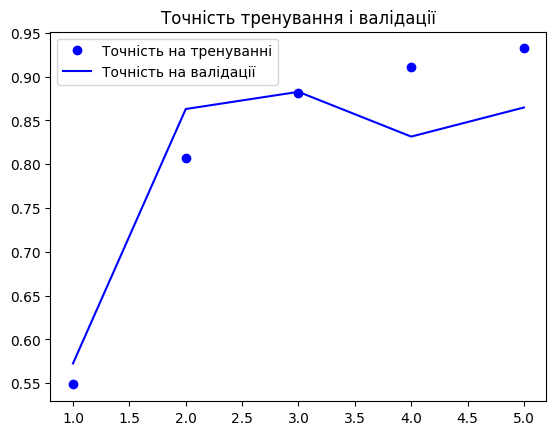

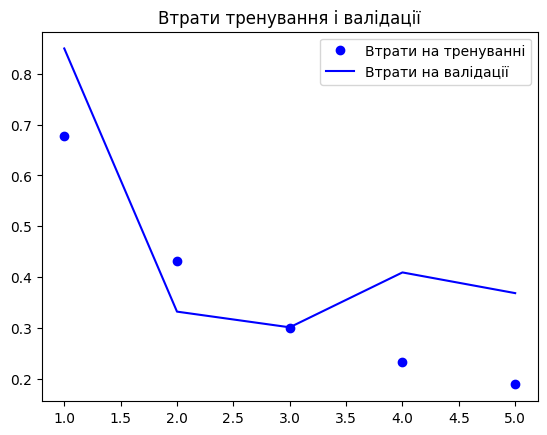

In [ ]:
# Відображення результатів:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Точність на тренуванні')  # Графік точності на тренувальних данних
plt.plot(epochs, val_acc, 'b', label='Точність на валідації')  # Графік точності на валідаційних данних
plt.title('Точність тренування і валідації')  # Заголовок графіку
plt.legend()  # Показати легенду

plt.figure()

plt.plot(epochs, loss, 'bo', label='Втрати на тренуванні')  # Графік втрат на тренувальних данних
plt.plot(epochs, val_loss, 'b', label='Втрати на валідації')  # Графік втрат на валідаційних данних
plt.title('Втрати тренування і валідації')  # Заголовок графіку
plt.legend()  # Показати легенду

plt.show()  # Відобразити графіки




In [ ]:
# Прогнозування з використанням навченої моделі:

predictions = model.predict(input_test)

# Для отримання зрозумілішого вигляду прогнозів, їх можна перетворити в бінарний формат:
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Для порівняння можна вивести деякі прогнозовані значення поряд з фактичними значеннями
for i in range(10):
    print(f"Прогнозоване: {binary_predictions[i]}, Фактичне: {y_test[i]}")

# Додатковий крок: Оцінка моделі
# Це дасть загальну точність моделі на тестових даних
test_loss, test_acc = model.evaluate(input_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 82s 103ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 [==============================] - 82s 105ms/step - loss: 0.3789 - acc: 0.8576
Test Loss: 0.37885844707489014
Test Accuracy: 0.8575599789619446
